# Environment

In [1]:
# import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
import sys

In [2]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def render(self, cur_state=None):
        grid = np.zeros((self.num_rows, self.num_cols))

        for obs in self.obs_states:
            grid[obs[0], obs[1]] = 1
        for goal in self.goal_states:
            grid[goal[0], goal[1]] = 4
        for bad in self.bad_states:
            grid[bad[0], bad[1]] = 2
        for restart in self.restart_states:
            grid[restart[0], restart[1]] = 3
        for start in self.start_state:
            grid[start[0], start[1]] = 5
        
        if cur_state is not None:
            grid[cur_state[0], cur_state[1]] = 6

        cmap = colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23', '#F0FF00']) 
        
        plt.pcolor(grid, edgecolors='k', linewidths=3, cmap=cmap)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [3]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [4]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [5]:
row_col_to_seq(np.array([[5, 2]]), 10)
seq_to_col_row(25, 10)

array([[2, 5]])

<Figure size 640x480 with 0 Axes>

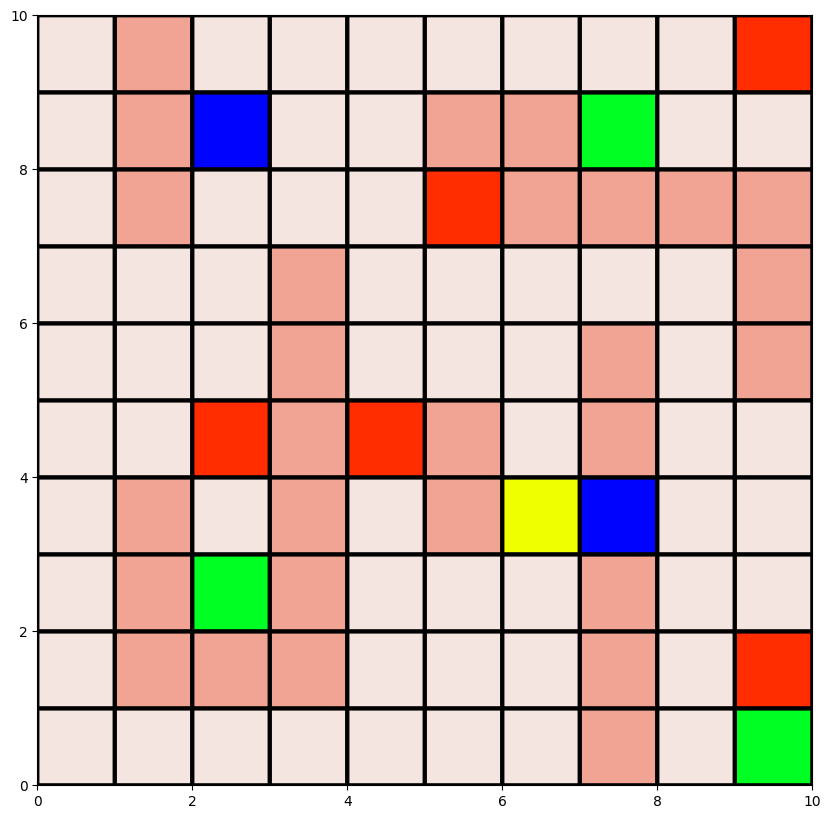

In [7]:
def plot(env):
    plt.clf()
    plt.figure(figsize=(num_rows,num_cols))
    env.render()
    plt.show()

plot(env)

# Starting conditions

In [8]:
start_states  = ((0, 4), (3, 6))
wind_states = ((False, 1.0), (False, 0.7), (True, 1.0))

init_states = [(x, y) for x in start_states for y in wind_states]


# Hyperparameters

In [9]:
from scipy.special import softmax
import random

seed = 42
rg = np.random.RandomState(seed)

def argmax_4(arr):
    best_val = arr[0]
    best_ind = 0
    cur_val = arr[1]
    if cur_val > best_val:
        best_val = cur_val
        best_ind = 1
    cur_val = arr[2]
    if cur_val > best_val:
        best_val = cur_val
        best_ind = 2
    cur_val = arr[3]
    if cur_val > best_val:
        best_val = cur_val
        best_ind = 3
    return best_ind

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    arr = Q[state[0], state[1]]
    rand_arm = random.getrandbits(2)
    best_arm = argmax_4(arr)
    index = (rg.random()<epsilon)
    return (best_arm, rand_arm)[index]

# Softmax
def choose_action_softmax(Q, state, tau=0, rg=rg):
    arr = Q[state[0], state[1]]
    exp = np.exp(arr/tau)
    probs = exp/np.sum(exp)
    return rg.choice(4, p=probs)

In [10]:
# choose_action_softmax(Q, (5, 5), tau=1, rg=rg)
# (Q[5, 5], 1)

In [11]:
tau = (0.1, 1, 10)
epsilon = (0.1, 0.2, 0.3)
policy = tuple((choose_action_epsilon, e) for e in epsilon)  + tuple((choose_action_softmax, t) for t in tau)
alpha = (0.2, 0.4, 0.8)
gamma = (0.9, 0.95, 0.99)

params = [(a, g, p) for a in alpha for g in gamma for p in policy]



# Sarsa

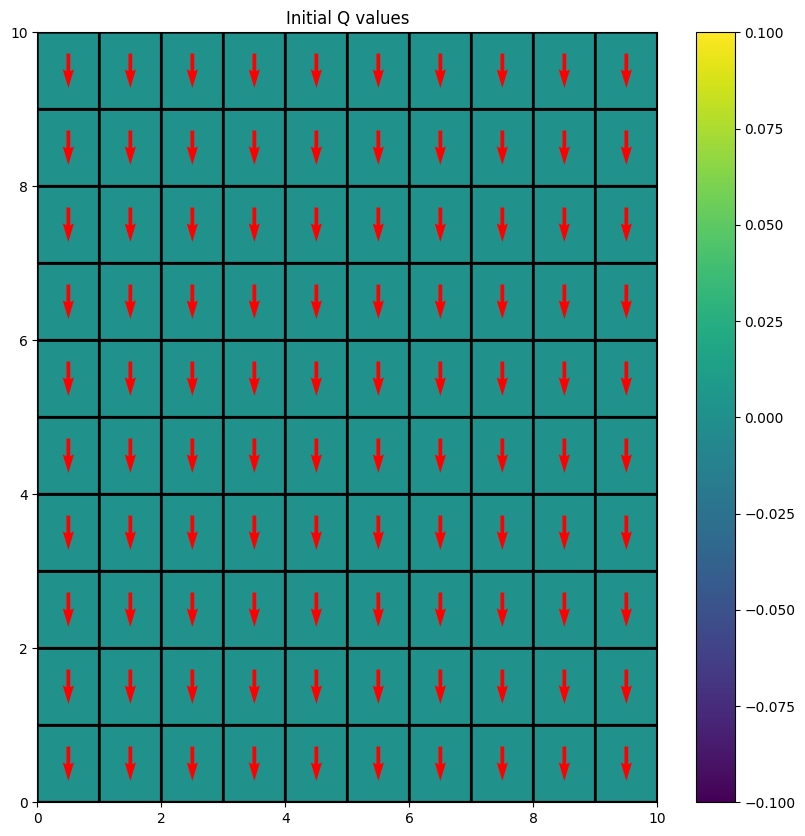

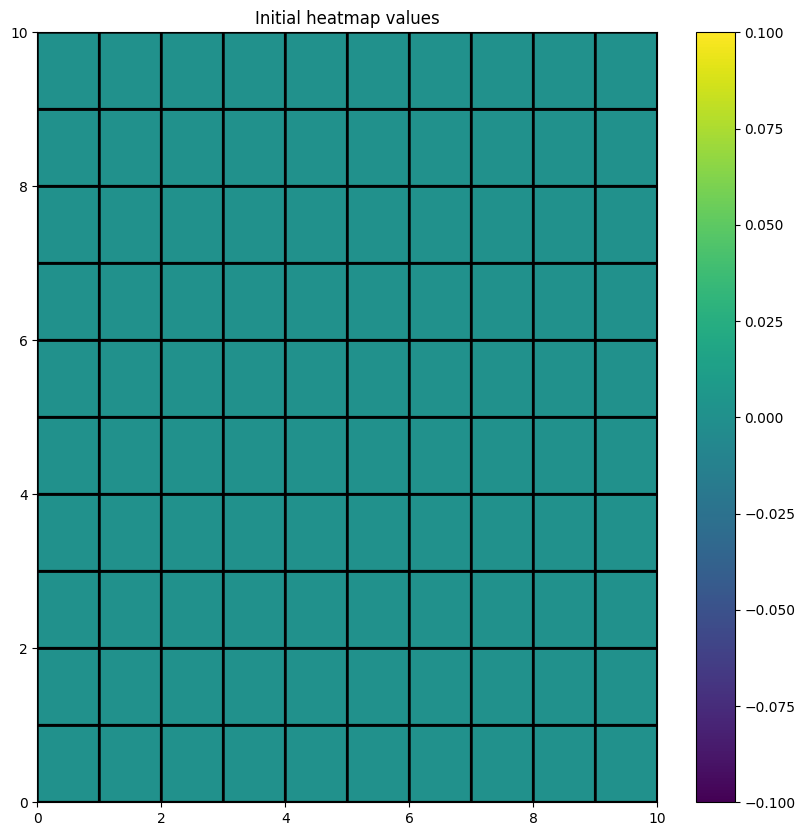

In [30]:
# Q values
Q = np.zeros((num_rows, num_cols, 4))
heatmap = np.zeros((num_rows, num_cols))
episodes = 5000

def plot_Q(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 1 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()


def plot_heatmap(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q, edgecolors='k', linewidths=2)
    plt.colorbar()
    # def x_direct(a):
    #     if a in [0, 1]:
    #         return 0
    #     return 1 if a == 3 else -1
    # def y_direct(a):
    #     if a in [3, 2]:
    #         return 0
    #     return 1 if a == 1 else -1
    # policy = Q
    # policyx = np.vectorize(x_direct)(policy)
    # policyy = np.vectorize(y_direct)(policy)
    # idx = np.indices(policy.shape)
    # plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()



def clear_output(wait=False):
    """Clear the output of the current cell receiving output.

    Parameters
    ----------
    wait : bool [default: false]
        Wait to clear the output until new output is available to replace it."""
    from IPython.core.interactiveshell import InteractiveShell
    if InteractiveShell.initialized():
        InteractiveShell.instance().display_pub.clear_output(wait)
    else:
        print('\033[2K\r', end='')
        sys.stdout.flush()
        print('\033[2K\r', end='')
        sys.stderr.flush()

plot_Q(Q, "Initial Q values")
plot_heatmap(heatmap, "Initial heatmap values")

In [34]:
# constants
def sarsa(Q, env, start_state, policy, alpha, gamma, episodes, plot=True):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    heatmap = np.zeros((num_rows, num_cols))

    for episode in tqdm(range(episodes)):
        state = env.reset()
        state_rc = seq_to_col_row(state, num_cols)[0]
        action = policy[0](Q, state_rc, policy[1])
        done = False
        rewards = 0
        steps = 0
        while not done and steps <= 100:
            heatmap[state_rc[0], state_rc[1]] += 1
            next_state, reward = env.step(state, action)
            done = (next_state in env.goal_states_seq)
            next_state_rc = seq_to_col_row(next_state, num_cols)[0]
            next_action = policy[0](Q, next_state_rc, policy[1])
            Q[state_rc[0], state_rc[1], action] += alpha * (reward + gamma * Q[next_state_rc[0], next_state_rc[1], next_action] - Q[state_rc[0], state_rc[1], action])
            state = next_state
            state_rc = next_state_rc
            action = next_action
            rewards += reward
            steps += 1
            # print(env.goal_states_seq)
        episode_rewards[episode] = rewards
        steps_to_completion[episode] = steps
        # print(steps)
        if episode % 100 == 0 and plot:
            clear_output(wait=True)
            plot_Q(Q, f"Q values for policy = {policy[0].__name__}, value = {policy[1]}: reward={episode_rewards[episode]}, steps={steps_to_completion[episode]}")

    return heatmap, episode_rewards, steps_to_completion

In [35]:
start, (wind, transition) = init_states[4]
    # print(start, wind, transition)
env.wind = wind
env.p_good_trans = transition
env.start_state = np.array([start])
    # start_state = row_col_to_seq(env.start_state, num_cols)[0]
    # print(start_state)
env = env.create_gridworld()
    # print(env.goal_states_se)

Q = np.zeros((num_rows, num_cols, 4))
episodes = 10000   

    # for a, g, (p, val) in params:
    #     print(a, g, p, val)
    #     sarsa(Q, env, start, (p, val), a, g, episodes)
    #     plot_Q(Q, f"Q values for alpha = {a}, gamma = {g}, policy = {p.__name__}, value = {val}")
sarsa(Q, env, start, (choose_action_softmax, 0.5), 0.5, 0.9, episodes)

  8%|▊         | 800/10000 [00:04<00:55, 165.27it/s]


KeyboardInterrupt: 

In [26]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    # print(state)
    state_rc = seq_to_col_row(state, num_cols)[0]
    state, reward= env.step(state, Q[state_rc[0], state_rc[1]].argmax())
    print(state, Q[state_rc[0], state_rc[1]].argmax())
    done = (state in env.goal_states_seq)
    plt.figure(figsize=(10, 10))
    env.render(cur_state=state_rc)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

5 0


KeyboardInterrupt: 

In [38]:
for start, (wind, transition) in init_states:
    # print(start, wind, transition)
    env.wind = wind
    env.p_good_trans = transition
    env.start_state = np.array([start])
    # start_state = row_col_to_seq(env.start_state, num_cols)[0]
    # print(start_state)
    env = env.create_gridworld()
    # print(env.goal_states_se)

    Q = np.zeros((num_rows, num_cols, 4))
    episodes = 10000   
    best_reward = -np.inf
    best_params = None
    for a, g, (p, val) in params:
        print(a, g, p, val)
        heatmap, rewards, steps = sarsa(Q, env, start, (p, val), a, g, episodes, plot=False)
        if best_reward < rewards[-1]:
            best_reward = rewards[-1]
            best_params = a, g, (p, val)
    
    a, g, (p, val) = best_params
    plot_Q(Q, f"Q values for alpha = {a}, gamma = {g}, policy = {p.__name__}, value = {val}")
    plot_heatmap(heatmap, "Heatmap for states visited")
    # sarsa(Q, env, start, (choose_action_epsilon, 0.2), 0.4, 0.999, episodes)

0.2 0.9 <function choose_action_epsilon at 0x7373e02fe8e0> 0.1


100%|██████████| 10000/10000 [00:03<00:00, 2977.31it/s]


0.2 0.9 <function choose_action_epsilon at 0x7373e02fe8e0> 0.2


100%|██████████| 10000/10000 [00:03<00:00, 2819.27it/s]


0.2 0.9 <function choose_action_epsilon at 0x7373e02fe8e0> 0.3


100%|██████████| 10000/10000 [00:04<00:00, 2223.07it/s]


0.2 0.9 <function choose_action_softmax at 0x7373e01fafc0> 0.1


100%|██████████| 10000/10000 [00:06<00:00, 1608.69it/s]


0.2 0.9 <function choose_action_softmax at 0x7373e01fafc0> 1


100%|██████████| 10000/10000 [00:15<00:00, 661.64it/s]


0.2 0.9 <function choose_action_softmax at 0x7373e01fafc0> 10


100%|██████████| 10000/10000 [00:47<00:00, 208.46it/s]


0.2 0.95 <function choose_action_epsilon at 0x7373e02fe8e0> 0.1


100%|██████████| 10000/10000 [00:03<00:00, 3246.47it/s]


0.2 0.95 <function choose_action_epsilon at 0x7373e02fe8e0> 0.2


100%|██████████| 10000/10000 [00:03<00:00, 2743.44it/s]


0.2 0.95 <function choose_action_epsilon at 0x7373e02fe8e0> 0.3


100%|██████████| 10000/10000 [00:04<00:00, 2260.92it/s]


0.2 0.95 <function choose_action_softmax at 0x7373e01fafc0> 0.1


100%|██████████| 10000/10000 [00:07<00:00, 1360.86it/s]


0.2 0.95 <function choose_action_softmax at 0x7373e01fafc0> 1


100%|██████████| 10000/10000 [00:10<00:00, 967.98it/s]


0.2 0.95 <function choose_action_softmax at 0x7373e01fafc0> 10


100%|██████████| 10000/10000 [00:46<00:00, 214.88it/s]


0.2 0.99 <function choose_action_epsilon at 0x7373e02fe8e0> 0.1


 19%|█▉        | 1907/10000 [00:00<00:02, 2898.71it/s]


KeyboardInterrupt: 

# Q Learning 

In [15]:
# constants
def Qlearning(Q, env, start_state, policy, alpha, gamma, episodes):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)

    for episode in tqdm(range(episodes)):
        state = env.reset()
        state_rc = seq_to_col_row(state, num_cols)[0]
        action = policy[0](Q, state_rc, policy[1])
        done = False
        rewards = 0
        steps = 0
        while not done and steps <= 100:
            next_state, reward = env.step(state, action)
            done = (next_state in env.goal_states_seq)
            next_state_rc = seq_to_col_row(next_state, num_cols)[0]
            # print(next_state, next_state_rc)
            # if d?one:
                # print(state_rc, next_state_rc, action, reward)
            next_action = policy[0](Q, next_state_rc, policy[1])
            best_action = argmax_4(Q[next_state_rc[0], next_state_rc[1]])
            Q[state_rc[0], state_rc[1], action] += alpha * (reward + gamma * (Q[next_state_rc[0], next_state_rc[1], best_action]) - Q[state_rc[0], state_rc[1], action])
            state = next_state
            state_rc = next_state_rc
            action = next_action
            rewards += reward
            steps += 1
            # print(env.goal_states_seq)
        episode_rewards[episode] = rewards
        steps_to_completion[episode] = steps
        # print(steps)
        if episode % 100 == 0:
            clear_output(wait=True)
            plot_Q(Q, f"Q values for policy = {policy[0].__name__}, value = {policy[1]}: reward={episode_rewards[episode]}, steps={steps_to_completion[episode]}")

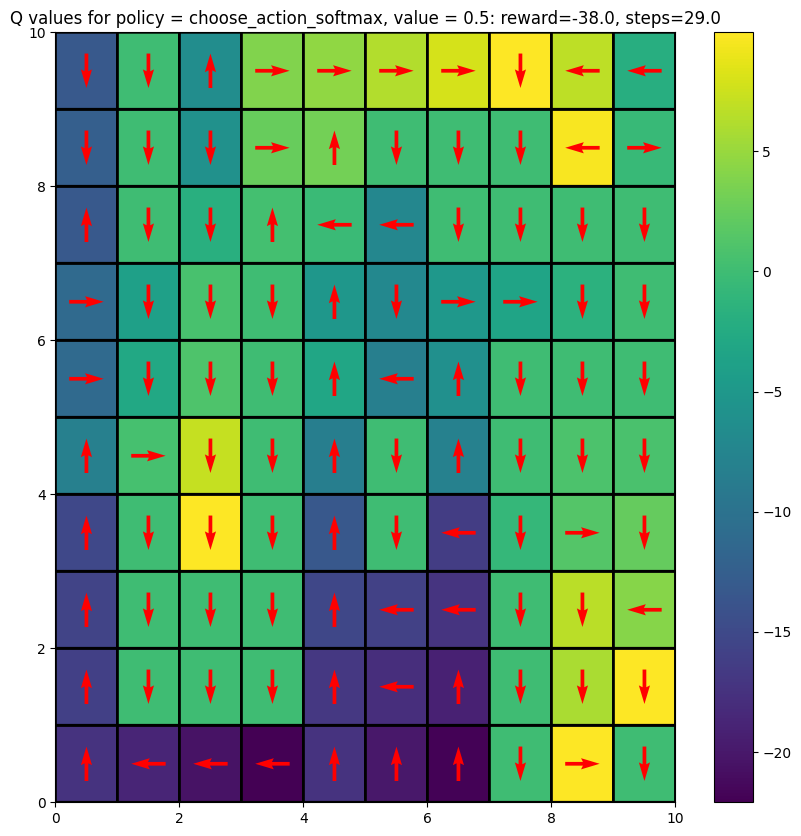

100%|██████████| 10000/10000 [00:38<00:00, 261.93it/s]


In [16]:
start, (wind, transition) = init_states[4]
    # print(start, wind, transition)
env.wind = wind
env.p_good_trans = transition
env.start_state = np.array([start])
    # start_state = row_col_to_seq(env.start_state, num_cols)[0]
    # print(start_state)
env = env.create_gridworld()
    # print(env.goal_states_se)

Q = np.zeros((num_rows, num_cols, 4))
episodes = 10000   

    # for a, g, (p, val) in params:
    #     print(a, g, p, val)
    #     sarsa(Q, env, start, (p, val), a, g, episodes)
    #     plot_Q(Q, f"Q values for alpha = {a}, gamma = {g}, policy = {p.__name__}, value = {val}")
Qlearning(Q, env, start, (choose_action_softmax, 0.5), 0.5, 0.99, episodes)

87 0


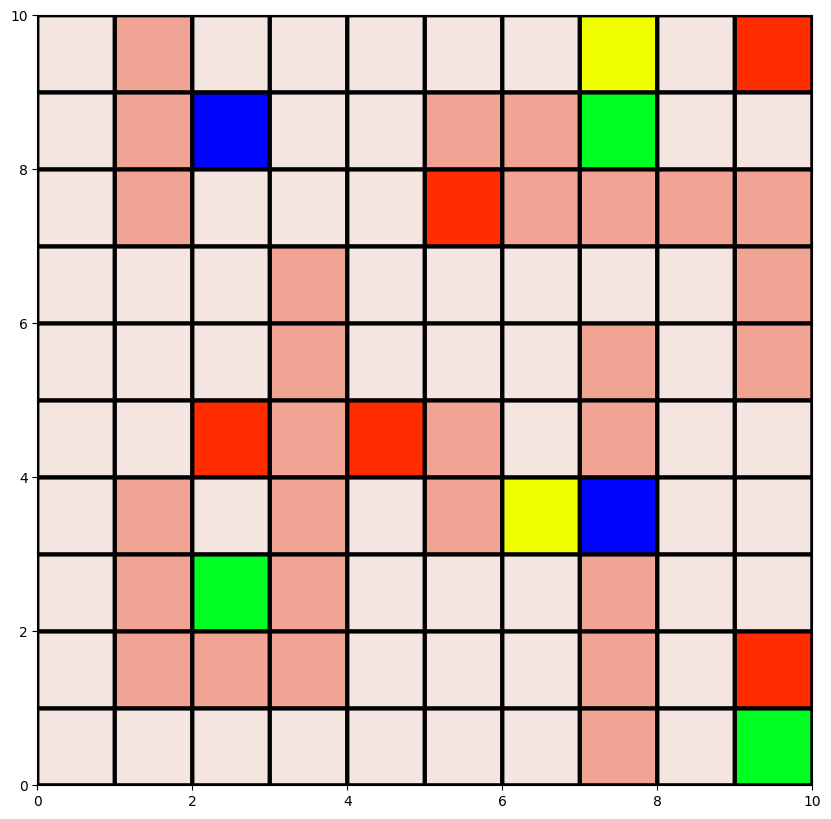

Steps: 28, Total Reward: -22


In [17]:

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    # print(state)
    state_rc = seq_to_col_row(state, num_cols)[0]
    state, reward= env.step(state, Q[state_rc[0], state_rc[1]].argmax())
    print(state, Q[state_rc[0], state_rc[1]].argmax())
    done = (state in env.goal_states_seq)
    plt.figure(figsize=(10, 10))
    env.render(cur_state=state_rc)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))